In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import nltk
## To download vader files
#nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from scipy.stats import spearmanr, pearsonr

<h3> Raw Data </h3>

In [2]:
webmd_raw = pd.read_csv('webmd.csv')
webmd_raw.shape

(362806, 12)

<h3> Data preprocessing </h3>

In [3]:
webmd = pd.read_csv('webmd_conditions_transformed.csv',parse_dates=['Date'])
column_list = list(webmd.columns.values)
column_list_lower = map(lambda x: x.lower(), column_list)
webmd.columns = column_list_lower
webmd.shape

(313039, 13)

In [4]:
webmd.head()

,age,condition,date,drug,drugid,easeofuse,effectiveness,reviews,satisfaction,sex,sides,usefulcount,rating
0,75 or over,Allergic Rhinitis,2014-09-21,25dph-7.5peh,146724,5,5,I'm a retired physician and of all the meds I ...,5,Male,"Drowsiness, dizziness , dry mouth /nose/thro...",0,10
1,25-34,Cold Symptoms,2011-01-13,25dph-7.5peh,146724,5,5,cleared me right up even with my throat hurtin...,5,Female,"Drowsiness, dizziness , dry mouth /nose/thro...",1,10
2,25-34,Birth Control,2017-06-15,wymzya fe,163180,5,5,Haven't gotten pregnant so it does it's job. I...,2,Female,"Nausea , vomiting , headache , bloating , ...",0,8
3,45-54,Ovarian Cysts,2017-01-30,wymzya fe,163180,5,5,I have take this for 5 years age 45-50 to prev...,5,Female,"Nausea , vomiting , headache , bloating , ...",0,10
4,25-34,Acne,2016-04-27,wymzya fe,163180,4,2,,2,Female,"Nausea , vomiting , headache , bloating , ...",1,5


<h1> Exploratory Data Analysis </h1> 

In [5]:
len(webmd.drug.unique())

5641

In [6]:
len(webmd.condition.unique())

1675

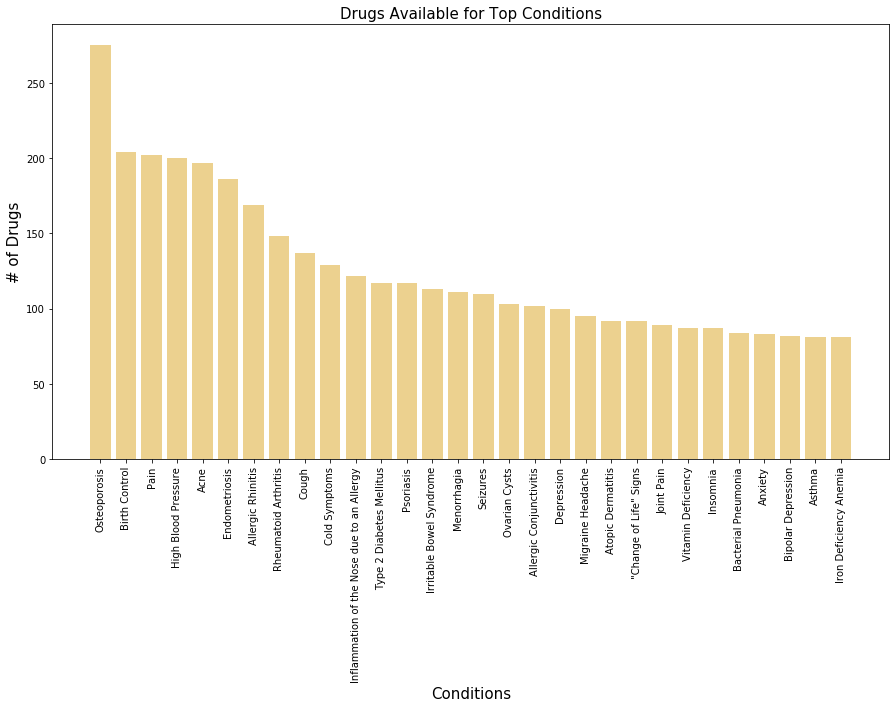

In [7]:
# Number of drugs available for top conditions
df = webmd.groupby(['condition'])['drug'].nunique().sort_values(ascending = False).reset_index().head(30)
plt.rcParams['figure.figsize'] = [15, 8]
plt.bar(x=df['condition'],height = df['drug'],color = 'goldenrod',alpha=0.5)
plt.xticks(rotation=90)
plt.title('Drugs Available for Top Conditions', fontsize = 15)
plt.xlabel('Conditions', fontsize = 15)
plt.ylabel('# of Drugs', fontsize = 15)
plt.show()

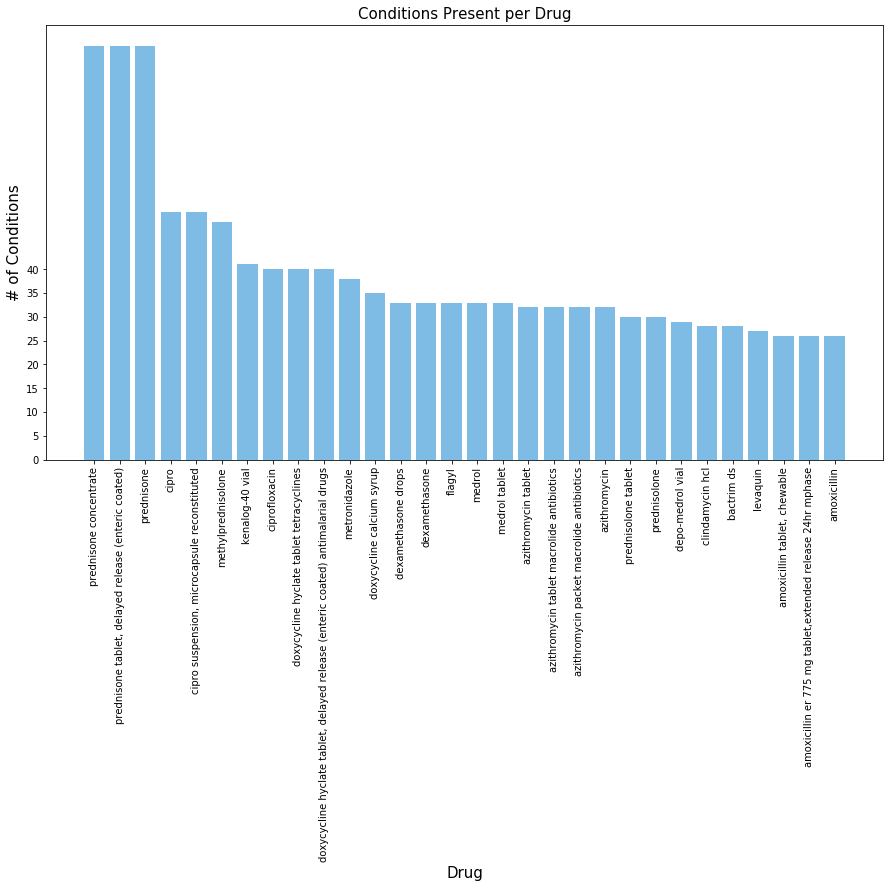

In [8]:
# Number of conditions present per drug
df = webmd.groupby(['drug'])['condition'].nunique().sort_values(ascending = False).reset_index().head(30)
plt.rcParams['figure.figsize'] = [15, 8]
plt.bar(x=df['drug'],height = df['condition'],color = '#007acc',alpha=0.5)

plt.title('Conditions Present per Drug', fontsize = 15)
plt.xlabel('Drug', fontsize = 15)
plt.ylabel('# of Conditions', fontsize = 15)
plt.xticks(rotation=90)
plt.yticks(np.arange(0,45,5))
plt.show()

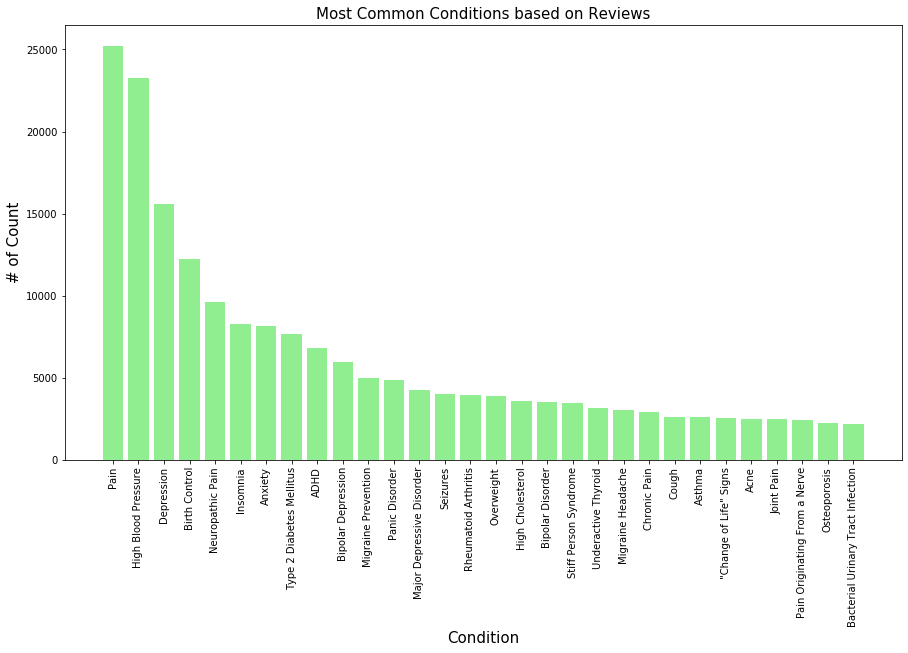

In [9]:
# Most Common Conditions based on Reviews
df = webmd['condition'].value_counts().head(30).reset_index()
df.columns = ['condition','count']
plt.rcParams['figure.figsize'] = [15, 8]
plt.bar(x=df['condition'],height = df['count'],color = 'lightgreen')
plt.xticks(rotation=90)
plt.title('Most Common Conditions based on Reviews', fontsize = 15)
plt.xlabel('Condition', fontsize = 15)
plt.ylabel('# of Count', fontsize = 15)
plt.show()

In [ ]:
# Top 10 drugs which are used for the top condition (Pain)
df = webmd[webmd['condition'] == 'Pain']['drug'].value_counts()[0: 10]
plt.rcParams['figure.figsize'] = (15, 8)
sns.barplot(x = df['index'], y = df['values'], palette = 'summer')
plt.title('Top 10 Drugs used for Depression',fontsize = 15)
plt.xlabel('Drug',fontsize = 15)
plt.ylabel('Drug Count',fontsize = 15)
plt.xticks(rotation=90)
plt.show()

In [11]:
# Converting the date into datetime format
webmd['date'] = pd.to_datetime(webmd['date'], errors = 'coerce')

# Extracting year, month and day from date
webmd['year'] = webmd['date'].dt.year

webmd['month'] = webmd['date'].dt.month

webmd['day'] = webmd['date'].dt.day

webmd.head()

,age,condition,date,drug,drugid,easeofuse,effectiveness,reviews,satisfaction,sex,sides,usefulcount,rating,year,month,day
0,75 or over,Allergic Rhinitis,2014-09-21,25dph-7.5peh,146724,5,5,I'm a retired physician and of all the meds I ...,5,Male,"Drowsiness, dizziness , dry mouth /nose/thro...",0,10,2014,9,21
1,25-34,Cold Symptoms,2011-01-13,25dph-7.5peh,146724,5,5,cleared me right up even with my throat hurtin...,5,Female,"Drowsiness, dizziness , dry mouth /nose/thro...",1,10,2011,1,13
2,25-34,Birth Control,2017-06-15,wymzya fe,163180,5,5,Haven't gotten pregnant so it does it's job. I...,2,Female,"Nausea , vomiting , headache , bloating , ...",0,8,2017,6,15
3,45-54,Ovarian Cysts,2017-01-30,wymzya fe,163180,5,5,I have take this for 5 years age 45-50 to prev...,5,Female,"Nausea , vomiting , headache , bloating , ...",0,10,2017,1,30
4,25-34,Acne,2016-04-27,wymzya fe,163180,4,2,,2,Female,"Nausea , vomiting , headache , bloating , ...",1,5,2016,4,27


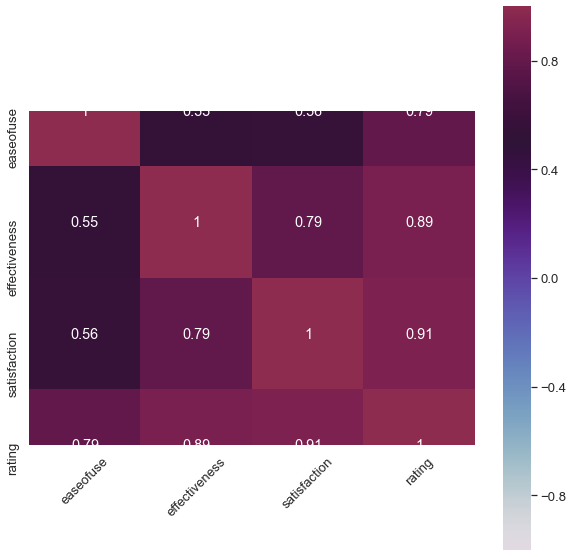

In [12]:
# Heatmap of the correlation matrix
plt.rcParams['figure.figsize'] = (10,10)
sns.set(font_scale = 1.2)
df = webmd[['easeofuse','effectiveness','satisfaction','rating']]
corr = df.corr()
sns.heatmap(corr, annot = True, vmin=-1, vmax=1, center=0.5,cmap='twilight', square=True);
plt.xticks(rotation = 45)
plt.show()

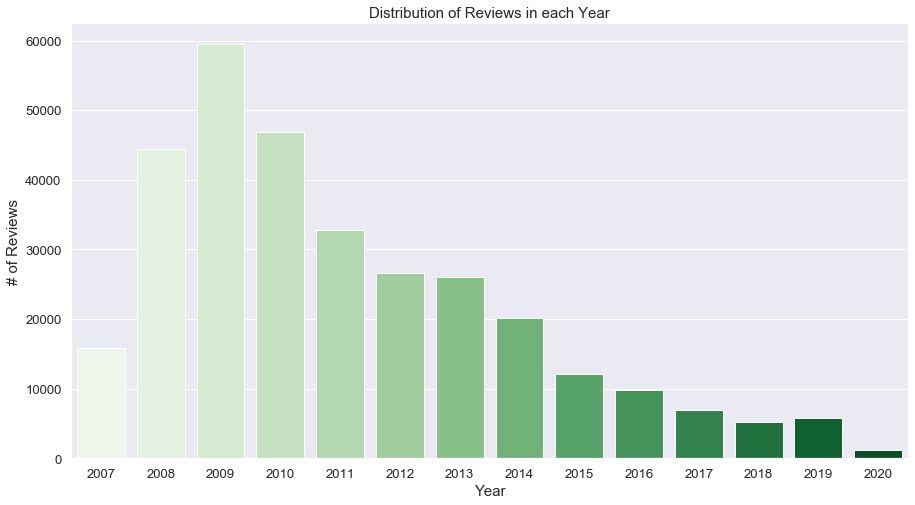

In [13]:
# Distribution of reviews in each year
plt.rcParams['figure.figsize'] = (15, 8)
sns.countplot(webmd['year'], palette ='Greens')
plt.title('Distribution of Reviews in each Year', fontsize = 15)
plt.xlabel('Year', fontsize = 15)
plt.ylabel('# of Reviews', fontsize = 15)
plt.show()

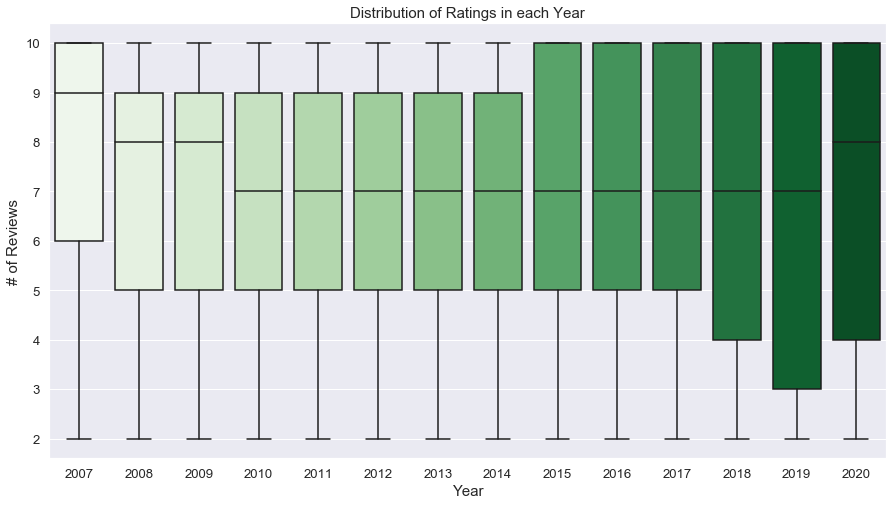

In [14]:
# Distribution of ratings in each month
plt.rcParams['figure.figsize'] = (15, 8)
sns.boxplot(x = webmd['year'], y = webmd['rating'],palette = 'Greens')
plt.title('Distribution of Ratings in each Year', fontsize = 15)
plt.xlabel('Year', fontsize = 15)
plt.ylabel('# of Reviews', fontsize = 15)
plt.show()

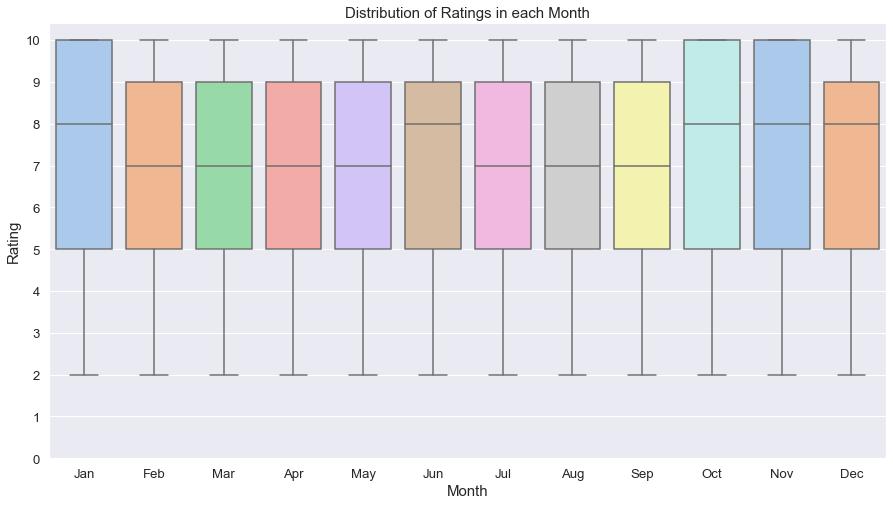

In [15]:
# Distribution of ratings in each month
plt.rcParams['figure.figsize'] = (15, 8)
sns.boxplot(x = webmd['month'], y = webmd['rating'], palette ='pastel')
plt.title('Distribution of Ratings in each Month', fontsize = 15)
plt.yticks(np.arange(0,11))
plt.xticks(np.arange(12),('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'))
plt.xlabel('Month', fontsize = 15)
plt.ylabel('Rating', fontsize = 15)
plt.show()

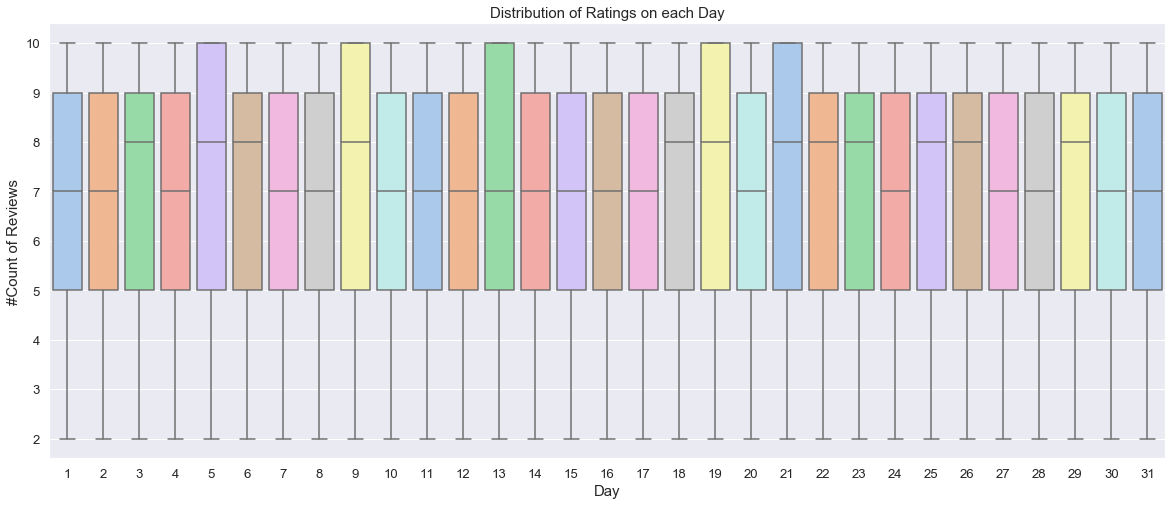

In [16]:
# Distribution of ratings on each day
plt.rcParams['figure.figsize'] = (20,8)
sns.boxplot(x = webmd['day'], y = webmd['rating'], palette ='pastel')
plt.title('Distribution of Ratings on each Day', fontsize = 15)
plt.xlabel('Day', fontsize = 15)
plt.ylabel('#Count of Reviews', fontsize = 15)
plt.show()

<h1>Sentiment Analysis</h1>

<h3> Sentiment analysis on user reviews. </h3>

In [17]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

<h3> Filtering missing reviews</h3>

In [18]:
print("Before removing missing reviews: ",webmd.shape)
webmd_df = webmd[webmd['reviews'] != " "]
print("After removing missing reviews: ",webmd_df.shape)

Before removing missing reviews:  (313039, 16)
After removing missing reviews:  (275204, 16)


In [ ]:
# Calculate sentiment polarity on each review
webmd_df['sentiment'] = webmd_df['reviews'].astype(str).apply(lambda x: sid.polarity_scores(x)['compound'])

In [ ]:
plt.figure(figsize=(15,5))
ax = sns.distplot(webmd_df['sentiment'],bins=80,kde=False)
plt.title('Sentiment Score Distribution')
plt.xlabel('Scores')
plt.ylabel('Count')

<h1> Statistical Analysis </h1>

<h3> Univariate Analysis (Ex: Pie chart) 
    - Distribution of review ratings </h3>

In [ ]:
# Frequency of each rating
df = webmd['rating'].value_counts().reset_index()

# Converting float rating values to int
df.columns = ['rating','count']
df = df.astype({'rating':'int'})

# Plotting user rating distribution
size = df['count']
colors = ['salmon','lavender','lightgreen','pink','wheat','azure','sienna','orange','turquoise','olive']
labels = df['rating']

my_circle = plt.Circle((0, 0), 0.7, color = 'white')

plt.rcParams['figure.figsize'] = (10, 10)
plt.pie(size,colors = colors,labels = labels, autopct = '%.2f%%')
plt.title('User Rating Distribution', fontsize = 15)
plt.legend()
p = plt.gcf()
plt.gca().add_artist(my_circle)
plt.show()

<h3> Bivariate analysis (Ex: scatter plot, joint plots) is used to show relationship between two variables.</h3>
<h3> 1. Joint plot of Sentiment Score vs Rating </h3>

In [ ]:
# Joint plot of sentiment score vs rating
reviews_per_drug = webmd_df.groupby(['drug']).agg({
    'index': pd.Series.nunique
})

drugs_sentiment = webmd_df.groupby(['drug'])

drugs_sentiment = drugs_sentiment.agg({
    'sentiment': np.mean, 
    'rating': np.mean,
    'index': pd.Series.nunique
})

drugs_sentiment = drugs_sentiment[drugs_sentiment['index'] > reviews_per_drug.quantile(q=0.75)[0]]

sns.jointplot(x= 'sentiment', y= 'rating', data=drugs_sentiment, kind='reg', height=8, scatter_kws={'s': 20})
print('Joint plot of Sentiment Score vs Rating')
plt.xticks(np.arange(-1,1,0.2))
plt.show()

<h3> 2. Average Useful Count vs Rating </h3>

In [ ]:
#Scatter plot of average useful_count vs rating
avg_useful_count_list = []

ratings = range(1, 11)

for i in ratings:
    avg_useful_count_list.append([i, np.sum(webmd[webmd['rating'] == i].usefulcount) / np.sum([webmd['rating'] == i])])
    
count_arr = np.asarray(avg_useful_count_list)

plt.rcParams['figure.figsize'] = (15, 8)
plt.scatter(count_arr[:, 0], count_arr[:, 1], c=count_arr[:, 0], cmap = 'coolwarm', s=400)
plt.title('Average Useful Count vs Rating',fontsize = 15)
plt.xlabel('Rating',fontsize = 15)
plt.ylabel('Average Useful Count',fontsize = 15)
plt.xticks(np.arange(1,11))
plt.yticks(np.arange(0,20,5))
plt.grid()
plt.show()

<h3> Correlation Coefficients (Between Sentiment Score and Rating) </h3>

In [ ]:
# Spearman correlation between sentiment and rating
spearmanr(webmd_df['sentiment'], webmd_df['rating'])

In [ ]:
# Pearson correlation between sentiment and rating
pearsonr(webmd_df['sentiment'], webmd_df['rating'])